In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Imports from PyCBC: https://pycbc.org/
from pycbc.catalog import Catalog
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform

In [3]:
# Values from Particle Data Group: https://pdg.lbl.gov/
# SI units
G = 6.67430e-11
c = 299792458
Msol = 1.98841e30
MSOL_TO_SEC = G * Msol / c**3

In [4]:
FONTSIZE = 25
FIGSIZE = 10

## Read in and clean data

In [5]:
# Check PyCBC catalog
c = Catalog(source='gwtc-3')
c.names

dict_keys(['GW200322_091133-v1', 'GW200316_215756-v1', 'GW200311_115853-v1', 'GW200308_173609-v1', 'GW200306_093714-v1', 'GW200302_015811-v1', 'GW200225_060421-v1', 'GW200224_222234-v1', 'GW200220_124850-v1', 'GW200220_061928-v1', 'GW200219_094415-v1', 'GW200216_220804-v1', 'GW200210_092254-v1', 'GW200209_085452-v1', 'GW200208_222617-v1', 'GW200208_130117-v1', 'GW200202_154313-v1', 'GW200129_065458-v1', 'GW200128_022011-v1', 'GW200115_042309-v2', 'GW200112_155838-v1', 'GW191230_180458-v1', 'GW191222_033537-v1', 'GW191219_163120-v1', 'GW191216_213338-v1', 'GW191215_223052-v1', 'GW191204_171526-v1', 'GW191204_110529-v1', 'GW191129_134029-v1', 'GW191127_050227-v1', 'GW191126_115259-v1', 'GW191113_071753-v1', 'GW191109_010717-v1', 'GW191105_143521-v1', 'GW191103_012549-v1'])

In [6]:
# Get event data
event_name = 'GW200115_042309'
m = c[event_name]

observatories = ['L1', 'H1']
n_obs = len(observatories)

fs = 4096

# Duration of time segment to extract
slice_duration = 256

strain_tseries, strain_fseries = {}, {}
for ifo in observatories:
    strain_tseries[ifo] = m.strain(ifo, duration=4096, sample_rate=fs).time_slice(m.time - slice_duration*2/3, m.time + slice_duration/3 + 4)
    strain_tseries[ifo] = highpass(strain_tseries[ifo], 15)
    strain_tseries[ifo] = strain_tseries[ifo].crop(4, 4)
    strain_fseries[ifo] = strain_tseries[ifo].to_frequencyseries() # FFT multiplied by a factor of delta_t = 1/fs

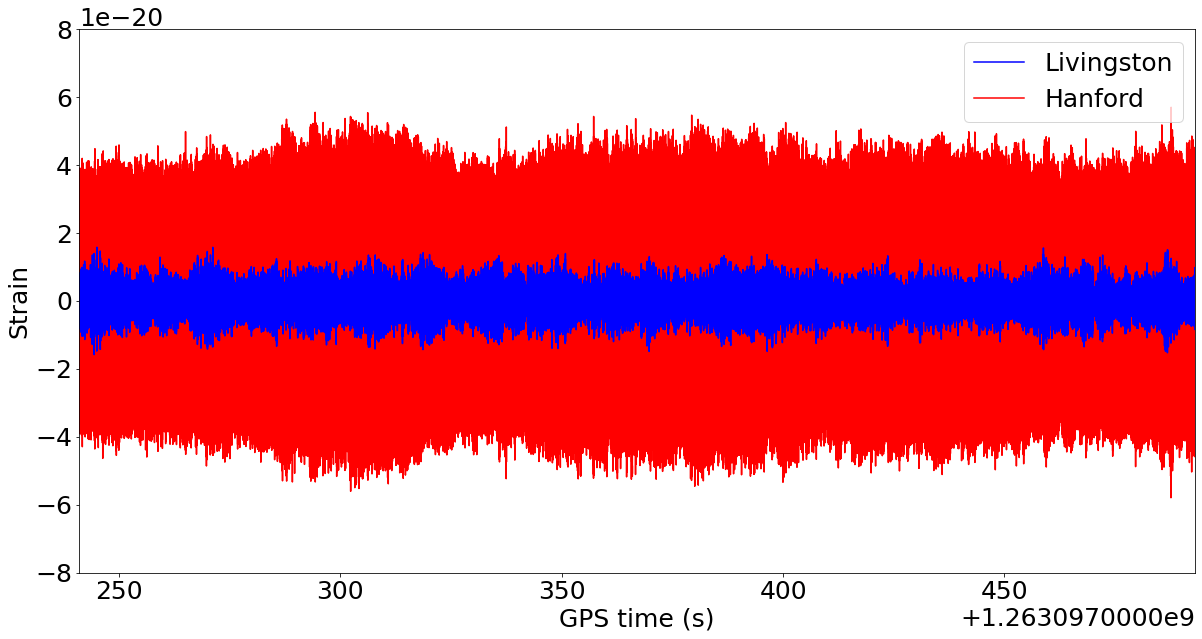

In [7]:
# Plot strain data
fig, ax = plt.subplots(figsize=(2*FIGSIZE,FIGSIZE))

ax.plot(strain_tseries['L1'].sample_times, strain_tseries['L1'][...], label='Livingston', color='b', zorder=2)
ax.plot(strain_tseries['H1'].sample_times, strain_tseries['H1'][...], label='Hanford', color='r', zorder=1)

ax.set_xlabel('GPS time (s)', fontsize=FONTSIZE)
ax.set_ylabel('Strain', fontsize=FONTSIZE)
ax.set_xlim([strain_tseries['L1'].sample_times[0], strain_tseries['L1'].sample_times[-1]])
ax.set_ylim([-8e-20, 8e-20])

ax.tick_params(axis='both', labelsize=FONTSIZE)
ax.xaxis.offsetText.set_fontsize(FONTSIZE)
ax.yaxis.offsetText.set_fontsize(FONTSIZE)
fig.legend(loc='upper right', bbox_to_anchor=(0.9,0.88), fontsize=FONTSIZE)
    
fig.savefig(f'figures/{event_name}_timeseries.pdf', format='pdf', bbox_inches='tight')

## Compute PSDs

In [8]:
# Compute PSDs
psd_fseries = {}
for ifo in observatories:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step. 
    psd_fseries[ifo] = interpolate(strain_tseries[ifo].psd(2), strain_fseries[ifo].delta_f)
    
    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    psd_fseries[ifo] = inverse_spectrum_truncation(psd_fseries[ifo],
                                                   int(2 * strain_tseries[ifo].sample_rate),
                                                   low_frequency_cutoff=15.0,
                                                   trunc_method='hann')

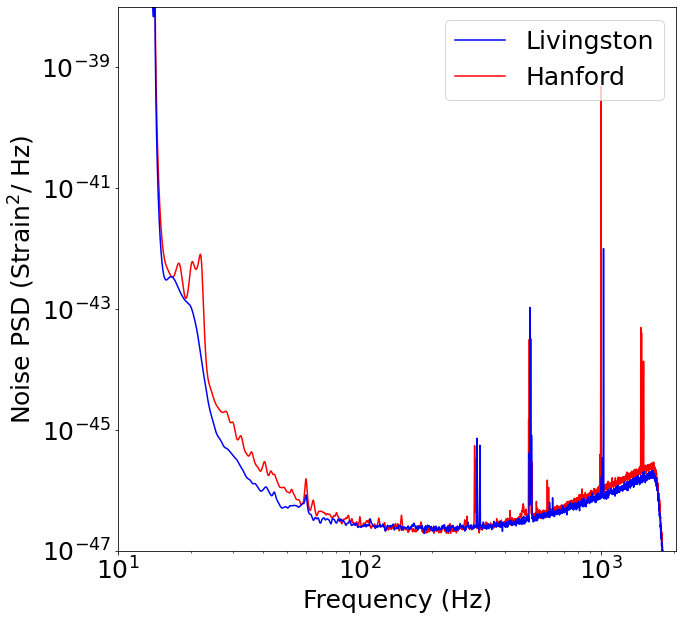

In [9]:
# Plot PSDs
fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

ax.loglog(psd_fseries['L1'].sample_frequencies, psd_fseries['L1'][...], label='Livingston', color='b', zorder=2)
ax.loglog(psd_fseries['H1'].sample_frequencies, psd_fseries['H1'][...], label='Hanford', color='r', zorder=1)

ax.set_xlabel('Frequency (Hz)', fontsize=FONTSIZE)
ax.set_ylabel(r'Noise PSD (Strain$^2 /$ Hz)', fontsize=FONTSIZE)
ax.set_xlim([10, fs/2])
ax.set_ylim([1e-47, 1e-38])

ax.tick_params(axis='both', labelsize=FONTSIZE)
fig.legend(loc='upper right', bbox_to_anchor=(0.9,0.88), fontsize=FONTSIZE)
    
fig.savefig(f'figures/{event_name}_psd.pdf', format='pdf', bbox_inches='tight')

## Write data to files

In [10]:
for ifo in observatories:
    np.savetxt(f'txt_data/{event_name}_strain_{ifo}.txt', (strain_tseries[ifo].sample_times, strain_tseries[ifo]))
    np.savetxt(f'txt_data/{event_name}_psd_{ifo}.txt', (psd_fseries[ifo].sample_frequencies, psd_fseries[ifo]))

## TaylorF2 waveform in the time domain

In [11]:
m1_signal = 7.58110 # Msol
m2_signal = 1.32952 # Msol

hplus_tseries, hcross_tseries = get_td_waveform(approximant="TaylorF2", mass1=m1_signal, mass2=m2_signal, f_lower=20, delta_t=strain_tseries[ifo].delta_t)

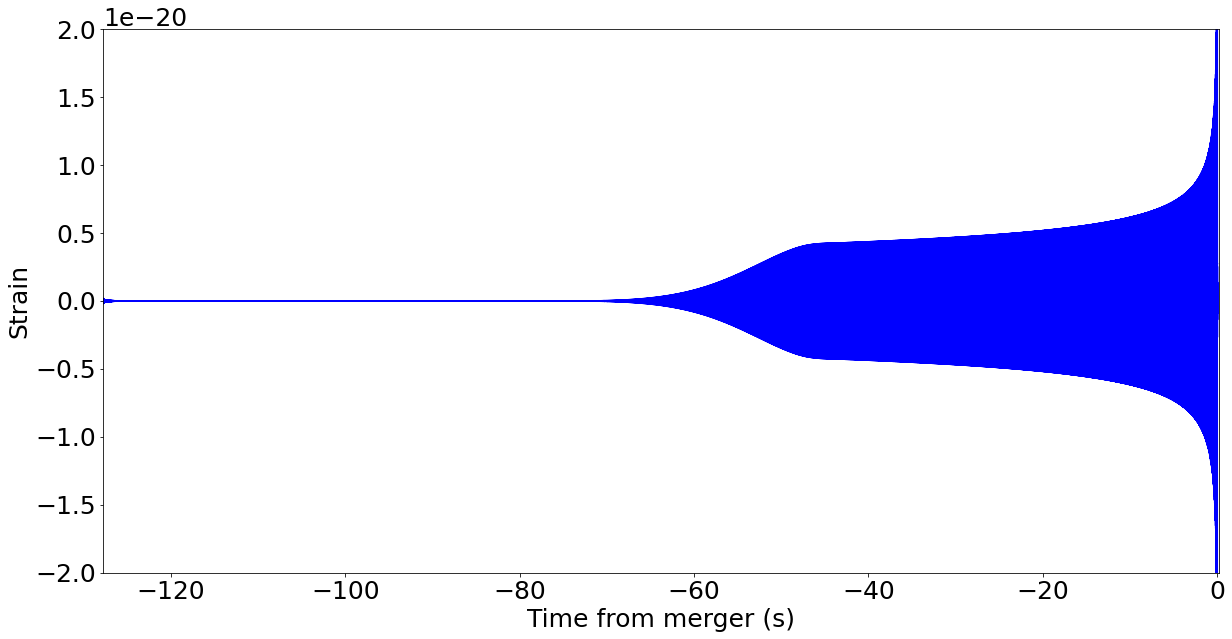

In [12]:
# Plot template
fig, ax = plt.subplots(figsize=(2*FIGSIZE,FIGSIZE))

ax.plot(hplus_tseries.sample_times, hplus_tseries[...], color='b')

ax.set_xlabel('Time from merger (s)', fontsize=FONTSIZE)
ax.set_ylabel('Strain', fontsize=FONTSIZE)
ax.set_xlim([hplus_tseries.sample_times[0], hplus_tseries.sample_times[-1]])
ax.set_ylim([-2e-20, 2e-20])

ax.tick_params(axis='both', labelsize=FONTSIZE)
ax.xaxis.offsetText.set_fontsize(FONTSIZE)
ax.yaxis.offsetText.set_fontsize(FONTSIZE)
    
fig.savefig(f'figures/{event_name}_template.pdf', format='pdf', bbox_inches='tight')

## Matched filtering

In [13]:
# Truncating frequency series for later analysis
freqs, strain, psd = {}, {}, {}
N_time, kL, kH = {}, {}, {}
for ifo in observatories:
    
    N_time[ifo] = len(strain_tseries[ifo][...])
    df = fs/N_time[ifo]
    
    fL = 20
    kL[ifo] = int( max(1, np.ceil(N_time[ifo]*fL/fs)) )
    
    v_lso = 1/np.sqrt(6)
    M_max = 12
    f_lso = v_lso**3 / (np.pi * M_max * MSOL_TO_SEC)
    kH[ifo] = int( min(np.floor((N_time[ifo]-1)/2), np.floor(N_time[ifo]*f_lso/fs)) )
    
    print(f'{ifo}: fL = {kL[ifo]*df}, fH = {kH[ifo]*df}')
    
    freqs_temp = strain_fseries[ifo].sample_frequencies[...]
    freqs[ifo] = freqs_temp[kL[ifo]:kH[ifo]+1]
    strain[ifo] = {'waveform': strain_fseries[ifo][...][kL[ifo]:kH[ifo]+1], 'freqs': freqs[ifo], 'df': df}
    psd[ifo] = {'waveform': psd_fseries[ifo][...][kL[ifo]:kH[ifo]+1], 'freqs': freqs[ifo], 'df': df}

L1: fL = 20.0, fH = 366.4285714285714
H1: fL = 20.0, fH = 366.4285714285714


In [14]:
# TaylorF2 template phase function is from https://doi.org/10.1103/PhysRevD.80.084043

def template_taylorf2( freqs, M, eta, tc=0 ):
    v_lso = 1/np.sqrt(6)
    v = np.real(( np.pi * M * MSOL_TO_SEC * freqs )**(1/3))
    phase = 2*np.pi*freqs*tc + (3/(128*eta*v**5)) * ( 1 + (20/9)*(743/336 + 11*eta/4)*v**2 - 16*np.pi*v**3 + 10*(3058673/1016064 + 5429*eta/1008 + 617*eta**2/144)*v**4 + np.pi*(38645/756 - 65*eta/9)*(1 + 3*np.log(v/v_lso))*v**5 + (11583231236531/4694215680 - 640*np.pi**2/3 - 6848*np.euler_gamma/21 - 6848*np.log(4*v)/21 + (-15737765635/3048192 + 2255*np.pi**2/12)*eta + 76055*eta**2/1728 - 127825*eta**3/1296)*v**6 + np.pi*(77096675/254016 + 378515*eta/1512 - 74045*eta**2/756)*v**7 )
    return {"waveform": np.exp(-1j * phase) / freqs**(7/6), "freqs": freqs, "df": freqs[1]-freqs[0]}

def template_overlap( h1, h2, noise_psd ):
    h1w = h1["waveform"]
    h2w = h2["waveform"]
    nw = noise_psd["waveform"]
    df = noise_psd["df"]
    return 4 * df * sum( np.conj(h1w)*h2w  / nw )

In [15]:
M_signal = m1_signal + m2_signal
eta_signal = m1_signal * m2_signal / M_signal**2

In [16]:
SNR = {}
for ifo in observatories:
    h = template_taylorf2(strain[ifo]['freqs'], M_signal, eta_signal)
    hw = h['waveform'] / np.sqrt(abs( template_overlap(h, h, psd[ifo]) ))
    padded_series = np.zeros(kL[ifo])
    padded_series = np.append(padded_series, np.conj(hw) * strain[ifo]['waveform'] / psd[ifo]['waveform'] )
    padded_series = np.append(padded_series, np.zeros(N_time[ifo]-kH[ifo]-1))
    SNR[ifo] = 4 * np.abs( fs * np.fft.ifft(padded_series) )

(0.0, 11.3)

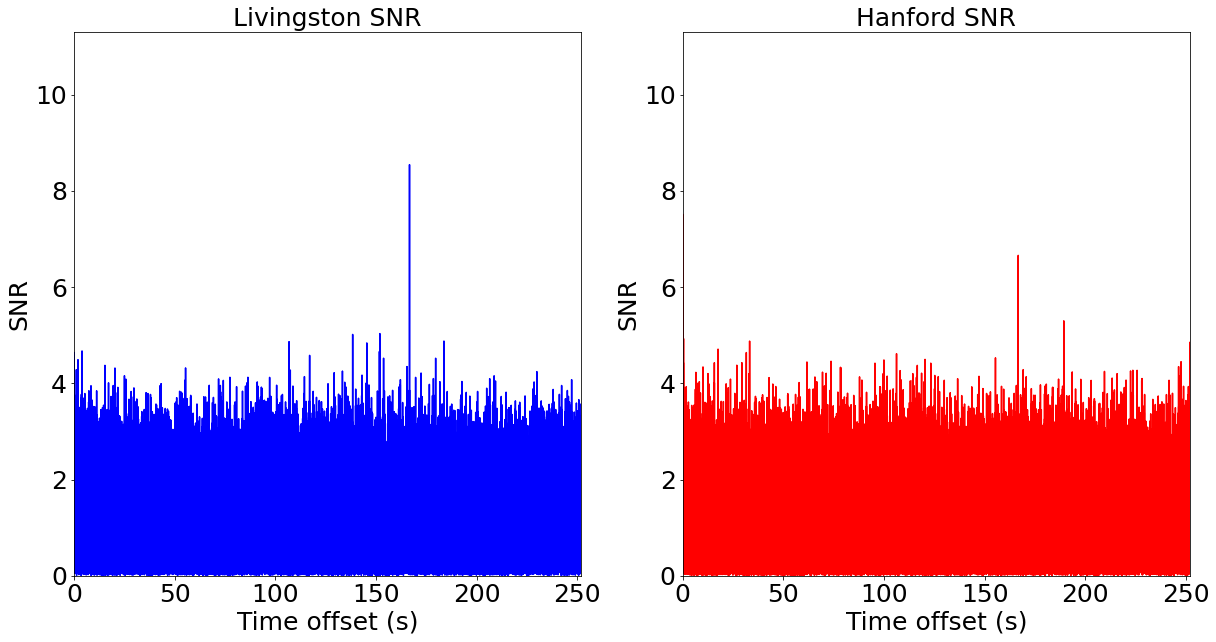

In [17]:
# Plot SNRs
fig, ax = plt.subplots(1, n_obs, figsize=(n_obs*FIGSIZE,FIGSIZE), squeeze=False)

ax[0,0].plot(strain_tseries['L1'].sample_times[...] - strain_tseries['L1'].sample_times[0], SNR['L1'], label='Livingston', color='b')
ax[0,0].set_xlabel('Time offset (s)', fontsize=FONTSIZE)
ax[0,0].set_ylabel('SNR', fontsize=FONTSIZE)
ax[0,0].tick_params(axis='both', labelsize=FONTSIZE)
ax[0,0].set_title('Livingston SNR', fontsize=FONTSIZE)
ax[0,0].set_xlim([0, strain_tseries['L1'].sample_times[-1] - strain_tseries['L1'].sample_times[0]])
ax[0,0].set_ylim([0, m.snr])
    
ax[0,1].plot(strain_tseries['H1'].sample_times[...] - strain_tseries['H1'].sample_times[0], SNR['H1'], label='Hanford', color='r')
ax[0,1].set_xlabel('Time offset (s)', fontsize=FONTSIZE)
ax[0,1].set_ylabel('SNR', fontsize=FONTSIZE)
ax[0,1].tick_params(axis='both', labelsize=FONTSIZE)
ax[0,1].set_title('Hanford SNR', fontsize=FONTSIZE)
ax[0,1].set_xlim([0, strain_tseries['H1'].sample_times[-1] - strain_tseries['H1'].sample_times[0]])
ax[0,1].set_ylim([0, m.snr])

In [18]:
# Time offset parameter: t_c
tc_signal = {}
for ifo in observatories:
    tc_signal[ifo] = strain_tseries[ifo].sample_times[np.argmax(SNR[ifo])] - strain_tseries[ifo].sample_times[0]
tc_signal

{'L1': 166.696533203125, 'H1': 0.0068359375}

In [19]:
# Signal SNR
snr_signal = {}
for ifo in observatories:
    snr_signal[ifo] = np.amax(SNR[ifo])
snr_signal

{'L1': 8.546038442216197, 'H1': 7.517258213468732}